In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


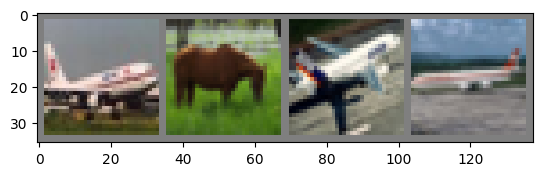

plane horse plane plane


In [3]:
# 이미지를 보여주기 위한 함수
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
class ConvLayer(nn.Module):
    
    def __init__(self, in_channels: int,out_channels: int, kernel_size: int = 3):
        super().__init__()
        
        self.conv2d = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=1)
        self.activation = nn.ReLU()
        self.maxpool2d = nn.MaxPool2d(kernel_size=2)
        
    def forward(self, x):
        
        return self.maxpool2d(self.activation(self.conv2d(x)))
        
class GlobalAvgPool2d(nn.Module):
    def __init__(self):
        super(GlobalAvgPool2d, self).__init__()

    def forward(self, x):
        # x: [batch_size, 64, 4, 4]
        
        # [batch_size, 64, 4, 4] -> [batch_size, 64]
        return torch.mean(x, dim=(2, 3))
        
        
class CNNModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv_1 = ConvLayer(in_channels=3, out_channels=32)
        self.conv_2 = ConvLayer(in_channels=32, out_channels=64)
        self.conv_3 = ConvLayer(in_channels=64, out_channels=64)
        
        self.global_pooling = GlobalAvgPool2d()
        
        self.dense = nn.Linear(64 ,10, bias=False)
        
        #self.softamx = nn.Softmax()
        
    def forward(self, x):
        
        # [batch_size, 3, 32, 32] -> [batch_size, 32, 16, 16]
        x = self.conv_1(x)
        
        # [batch_size, 32, 16, 16] -> [batch_size, 64, 8, 8]
        x = self.conv_2(x)
        
        # [batch_size, 64, 8, 8] -> [batch_size, 64 ,4, 4]
        x = self.conv_3(x)
        
        # [batch_size, 64, 4, 4]
        feature_map = x
        
        # [batch_size, 64, 4, 4] -> [batch_size, 64]
        x = self.global_pooling(x)
        
        # [batch_size, 64] -> [batch_size, 10]
        x = self.dense(x)
        
        #x = self.softmax(x)
        
        return x, feature_map

In [5]:
model = CNNModel()

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model.to(device)

device: cuda


CNNModel(
  (conv_1): ConvLayer(
    (conv2d): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activation): ReLU()
    (maxpool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_2): ConvLayer(
    (conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activation): ReLU()
    (maxpool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_3): ConvLayer(
    (conv2d): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activation): ReLU()
    (maxpool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (global_pooling): GlobalAvgPool2d()
  (dense): Linear(in_features=64, out_features=10, bias=False)
)

In [9]:
for epoch in range(2):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        prediction, feature_map = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.169
[1,  4000] loss: 1.965
[1,  6000] loss: 1.811
[1,  8000] loss: 1.711
[1, 10000] loss: 1.683
[1, 12000] loss: 1.618
[2,  2000] loss: 1.540
[2,  4000] loss: 1.523
[2,  6000] loss: 1.474
[2,  8000] loss: 1.410
[2, 10000] loss: 1.381
[2, 12000] loss: 1.361
Finished Training


In [117]:
# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

test_idx = 1

test_image = images[test_idx].to(device)

# feature_map: [1, 64, 4, 4]
prediction, feature_map = model(test_image.unsqueeze(0))

class_index = np.argmax(prediction.to("cpu").detach().numpy(), axis = 1)[0]

# [64, 4, 4]
feature_map = feature_map.squeeze(0)

# [10, 64] -> [64, 1, 1]
dense_layer_weights = model.dense.weight[class_index].unsqueeze(1).unsqueeze(2)

# [64, 4, 4]
attention_map = feature_map * dense_layer_weights
attention_map = attention_map.to("cpu").detach().numpy()

print(f'ground truth label: {labels[test_idx]}, predicted label: {class_index} ({nn.functional.softmax(prediction)[0][class_index] * 100:.4f})%')
print('attention map size: ',np.shape(attention_map))

ground truth label: 3, predicted label: 5 (54.9667)%
attention map size:  (64, 4, 4)


/tmp/ipykernel_1928994/1898833200.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(f'ground truth label: {labels[test_idx]}, predicted label: {class_index} ({nn.functional.softmax(prediction)[0][class_index] * 100:.4f})%')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 4)


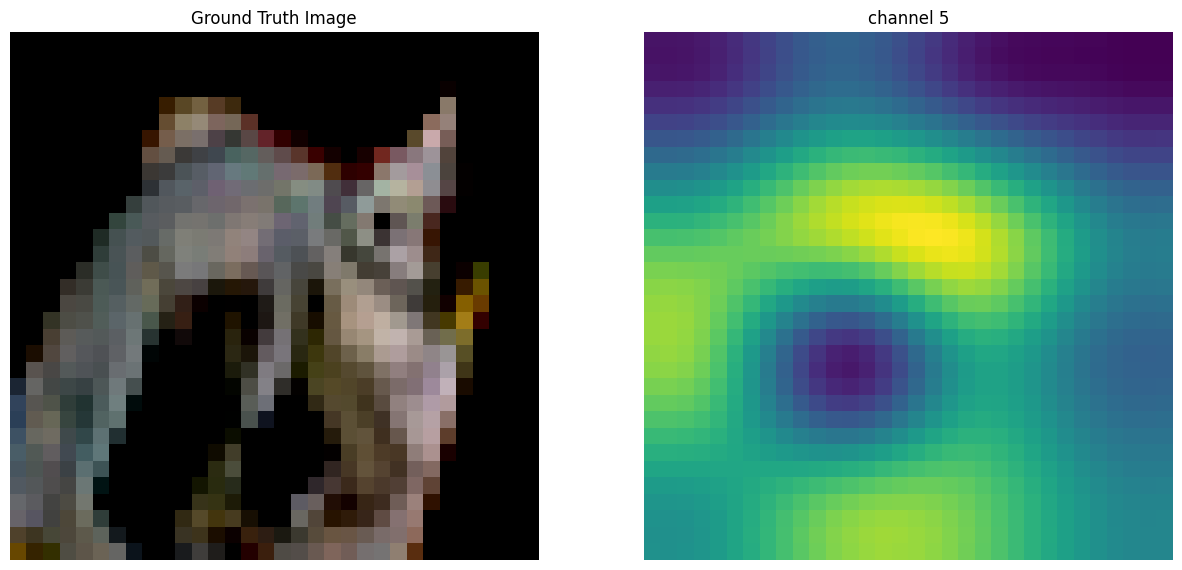

In [118]:
# [64, 4, 4]
attention_map = np.sum(attention_map, axis=0)
print(np.shape(attention_map))
attention_map = np.abs(attention_map)


figure = plt.figure(figsize=(15,15))

rows, cols = 1, 2

figure.add_subplot(rows, cols, 1)
img = test_image.permute(1,2,0)
plt.title("Ground Truth Image")
plt.axis('off')
plt.imshow(img.to("cpu").detach().numpy())

for i in range(2, rows*cols +1):
    img = attention_map
    img = cv2.resize(img, (32,32), interpolation = cv2.INTER_CUBIC)

    figure.add_subplot(rows, cols, i)
    plt.title(f"channel {class_index}")
    plt.axis('off')
    plt.imshow(img)

plt.show()